In [103]:
from keras.models import Sequential
from keras.layers import Convolution2D, BatchNormalization
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.preprocessing.image import ImageDataGenerator 
from keras.optimizers import SGD
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
import sklearn.metrics as metrics
import PIL

import os

import numpy as np

import matplotlib.pyplot as plt

In [104]:
# Parameters
img_width = 101
img_height = 101
batch_size = 64

In [105]:
import tensorflow as tf

keras = tf.keras

IMG_SHAPE = (img_height, img_width, 3)

base_model = tf.keras.applications.inception_v3.InceptionV3(input_shape=IMG_SHAPE, include_top=False, 
                                                      weights='imagenet', 
                                                      pooling='avg')


In [106]:
def plot_roc(labels, prediction_scores):
    fpr, tpr, _ = metrics.roc_curve(labels, prediction_scores, pos_label=1)
    auc = metrics.roc_auc_score(labels, prediction_scores)
    legend_string = 'AUC = {:0.3f}'.format(auc)
   
    plt.plot([0,1],[0,1],'--', color='gray', label='Chance')
    plt.plot(fpr, tpr, label=legend_string)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid('on')
    plt.axis('square')
    plt.legend()
    plt.tight_layout()
    
def load_data(dir_data, dir_labels, training=True):
    ''' Load each of the image files into memory 

    While this is feasible with a smaller dataset, for larger datasets,
    not all the images would be able to be loaded into memory

    When training=True, the labels are also loaded
    '''
    labels_pd = pd.read_csv(dir_labels)
    ids       = labels_pd.id.values
    data      = []
    for identifier in ids:
        fname     = dir_data + identifier.astype(str) + '.tif'
        image     = mpl.image.imread(fname)
        data.append(image)
    data = np.array(data) # Convert to Numpy array
    if training:
        labels = labels_pd.label.values
        return data, labels
    else:
        return data, ids
    
def cv_performance_assessment(X,y,k,clf):
    '''Cross validated performance assessment
    
    X   = training data
    y   = training labels
    k   = number of folds for cross validation
    clf = classifier to use
    
    Divide the training data into k folds of training and validation data. 
    For each fold the classifier will be trained on the training data and
    tested on the validation data. The classifier prediction scores are 
    aggregated and output
    '''
    # Establish the k folds
    prediction_scores = np.empty(y.shape[0],dtype='object')
    kf = StratifiedKFold(n_splits=k, shuffle=True)
    for train_index, val_index in kf.split(X, y):
        # Extract the training and validation data for this fold
        X_train, X_val   = X[train_index], X[val_index]
        y_train          = y[train_index]
        
        # Train the classifier
        X_train_features = X_train
        clf              = clf.fit(X_train_features,y_train)
        
        # Test the classifier on the validation data for this fold
        X_val_features   = X_val
        cpred            = clf.predict_proba(X_val_features)
        
        # Save the predictions for this fold
        prediction_scores[val_index] = cpred[:,1]
    return prediction_scores

In [107]:
# Get image data
train_data_dir = './data/training'
test_data_dir = './data/testing'
train_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

In [90]:
# Run this
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
import sklearn.metrics as metrics

dir_train_images  = './data/training/'
dir_test_images   = './data/testing/'
dir_train_labels  = './data/labels_training.csv'
dir_test_ids      = './data/sample_submission.csv'

labels_pd = pd.read_csv(dir_train_labels)
labels_0_sampled = labels_pd[labels_pd["label"] == 0].sample(n = 505)
labels_sampled = labels_0_sampled.append(labels_pd[labels_pd["label"] == 1])
ids       = labels_sampled.id.values
data      = []
for identifier in ids:
    fname     = dir_train_images + identifier.astype(str) + '.tif'
    image     = mpl.image.imread(fname)
    data.append(image)
data = np.array(data) # Convert to Numpy array


X = data/1500
y = labels_sampled.label.values

In [108]:
# Generate image label dataframe
# Dont run this
traindf = pd.read_csv("./data/labels_training.csv",dtype=str)
def append_ext(fn):
    return fn+".tif"
traindf["id"]=traindf["id"].apply(append_ext)
traindf = traindf.sample(frac=1)

train_generator = train_datagen.flow_from_dataframe( 
    dataframe=traindf,
    directory=train_data_dir, 
    x_col="id",
    y_col="label",
    seed=0,
    batch_size = batch_size,
    target_size=(img_height, img_width),
    shuffle=False,
    class_mode='binary',
    subset='training')

validation_generator = train_datagen.flow_from_dataframe( 
    dataframe=traindf,
    directory=train_data_dir, 
    x_col="id",
    y_col="label",
    seed=0,
    target_size=(img_height, img_width),
    class_mode='binary',
    subset='validation')

Found 1500 validated image filenames belonging to 2 classes.
Found 0 validated image filenames belonging to 2 classes.


## Try extracting features to do SVM ##

In [46]:
training_features = []
for i in range(1500):
    training_features.append(np.array(base_model(train_generator.next())).ravel())

In [47]:
np.savetxt("training_features_InceptionV3.csv", training_features, delimiter=",")

In [55]:
from sklearn import svm
from sklearn.metrics import classification_report
labels = train_generator.classes
clf = svm.SVC(kernel='rbf', degree = 3, probability=True, C=0.1, gamma='scale')
clf.fit(training_features, labels)

# Primary evaluation
score = clf.predict_proba(training_features)
auc = metrics.roc_auc_score(labels, score[:,1])
print(auc)
print (classification_report(labels, score[:,1]>0.5))

0.970727896910294
              precision    recall  f1-score   support

           0       0.91      0.96      0.93       995
           1       0.91      0.81      0.86       505

    accuracy                           0.91      1500
   macro avg       0.91      0.89      0.90      1500
weighted avg       0.91      0.91      0.91      1500



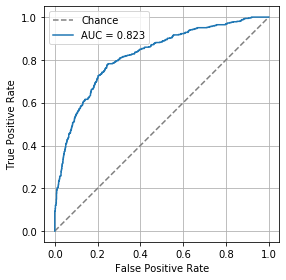

In [99]:
clf = svm.SVC(kernel='rbf', probability=True, C=1, gamma = 'scale')
# Perform cross validated performance assessment
prediction_scores = cv_performance_assessment(np.array(training_features),np.array(labels),5,clf)

# Compute and plot the ROC curves
plot_roc(labels, prediction_scores)

In [93]:
test_generator = test_datagen.flow_from_directory(
    directory=test_data_dir,
    target_size=(img_width, img_height),
    color_mode="rgb",
    class_mode=None,
    shuffle=False,
    seed=42,
    batch_size=1
)
testing_features = []
for i in range(558):
    testing_features.append(np.array(base_model(test_generator.next())).ravel())


Found 558 images belonging to 1 classes.


In [100]:
clf = svm.SVC(kernel='rbf', probability=True, C=1, gamma = 'scale')
clf.fit(training_features, labels)

score = clf.predict_proba(testing_features)
dir_test_ids      = './data/sample_submission.csv'
dir_test_images   = './data/testing/'
test_data, ids = load_data(dir_test_images, dir_test_ids, training=False)
# Save the predictions to a CSV file for upload to Kaggle
submission_file = pd.DataFrame({'id':    ids,
                                   'score':  score[:,1]})
submission_file.to_csv('Inception_SVM2.csv',
                           columns=['id','score'],
                           index=False)

In [102]:
peer = pd.read_csv('submission_PCA_SVM_3C.csv')
peer = pd.read_csv('Inception_SVM.csv')
np.corrcoef(score[:,1],np.array(peer.score))

array([[1.        , 0.90536866],
       [0.90536866, 1.        ]])

## Transfer learning ##

In [212]:
# Use transfer learning for feature extractor
base_model.trainable = False
prediction_layer = tf.keras.layers.Dense(2, activation = 'softmax', kernel_initializer='glorot_uniform')

In [214]:
model = tf.keras.Sequential([
    base_model,
    prediction_layer
])

In [246]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.005, beta_1=0.9, beta_2=0.999, amsgrad=False),
              loss=keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

In [224]:
callbackobj = tf.compat.v1.keras.callbacks.TensorBoard(log_dir='./Graph', histogram_freq=0,  
          write_graph=True, write_images=True, write_grads = True, update_freq = 1)

In [247]:
model.fit_generator(train_generator, epochs=20, class_weight={0:1., 1:3.5})

Epoch 1/20
24/24 [==============================] - 45s 2s/step - loss: 0.6503 - accuracy: 0.7833
Epoch 2/20
24/24 [==============================] - 46s 2s/step - loss: 0.5809 - accuracy: 0.8107
Epoch 3/20
24/24 [==============================] - 45s 2s/step - loss: 0.5106 - accuracy: 0.8367
Epoch 4/20
24/24 [==============================] - 45s 2s/step - loss: 0.5612 - accuracy: 0.8313
Epoch 5/20
24/24 [==============================] - 45s 2s/step - loss: 0.4930 - accuracy: 0.8540
Epoch 6/20
24/24 [==============================] - 45s 2s/step - loss: 0.4751 - accuracy: 0.8580
Epoch 7/20
24/24 [==============================] - 45s 2s/step - loss: 0.4498 - accuracy: 0.8780
Epoch 8/20
24/24 [==============================] - 45s 2s/step - loss: 0.4785 - accuracy: 0.8573
Epoch 9/20
24/24 [==============================] - 46s 2s/step - loss: 0.4425 - accuracy: 0.8667
Epoch 10/20
24/24 [==============================] - 45s 2s/step - loss: 0.4471 - accuracy: 0.8687
Epoch 11/20
24/24 [

In [193]:
keras.backend.clear_session()

In [248]:
#score = model.predict_generator(validation_generator)
#labels = validation_generator.classes


score = model.predict(train_generator)
labels = train_generator.classes
#plot_roc(labels, score.ravel())
auc = metrics.roc_auc_score(labels, score[:,1])
print(auc)
print (classification_report(labels, score[:,1]>=0.5))

0.6715786855067416
              precision    recall  f1-score   support

           0       0.74      0.76      0.75       995
           1       0.50      0.47      0.48       505

    accuracy                           0.66      1500
   macro avg       0.62      0.62      0.62      1500
weighted avg       0.66      0.66      0.66      1500



In [201]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 2048)              21802784  
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 4098      
Total params: 21,806,882
Trainable params: 4,098
Non-trainable params: 21,802,784
_________________________________________________________________


In [249]:
(model.get_weights())[-2]

array([[-0.26102132,  0.23642308],
       [ 0.09219537, -0.04005945],
       [ 0.1717199 , -0.13376535],
       ...,
       [ 0.01937469,  0.0455596 ],
       [ 0.14852433, -0.194773  ],
       [-0.2433232 ,  0.1743991 ]], dtype=float32)

(array([875.,  54.,  41.,  38.,  20.,  31.,  22.,  29.,  56., 334.]),
 array([2.0563792e-16, 1.0000000e-01, 2.0000000e-01, 3.0000001e-01,
        4.0000001e-01, 5.0000000e-01, 6.0000002e-01, 6.9999999e-01,
        8.0000001e-01, 8.9999998e-01, 1.0000000e+00], dtype=float32),
 <a list of 10 Patch objects>)

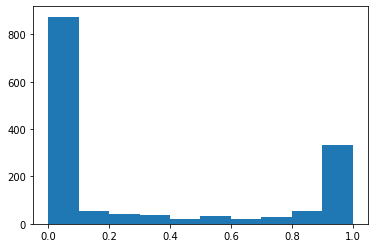

In [256]:
plt.hist(score[:,1])